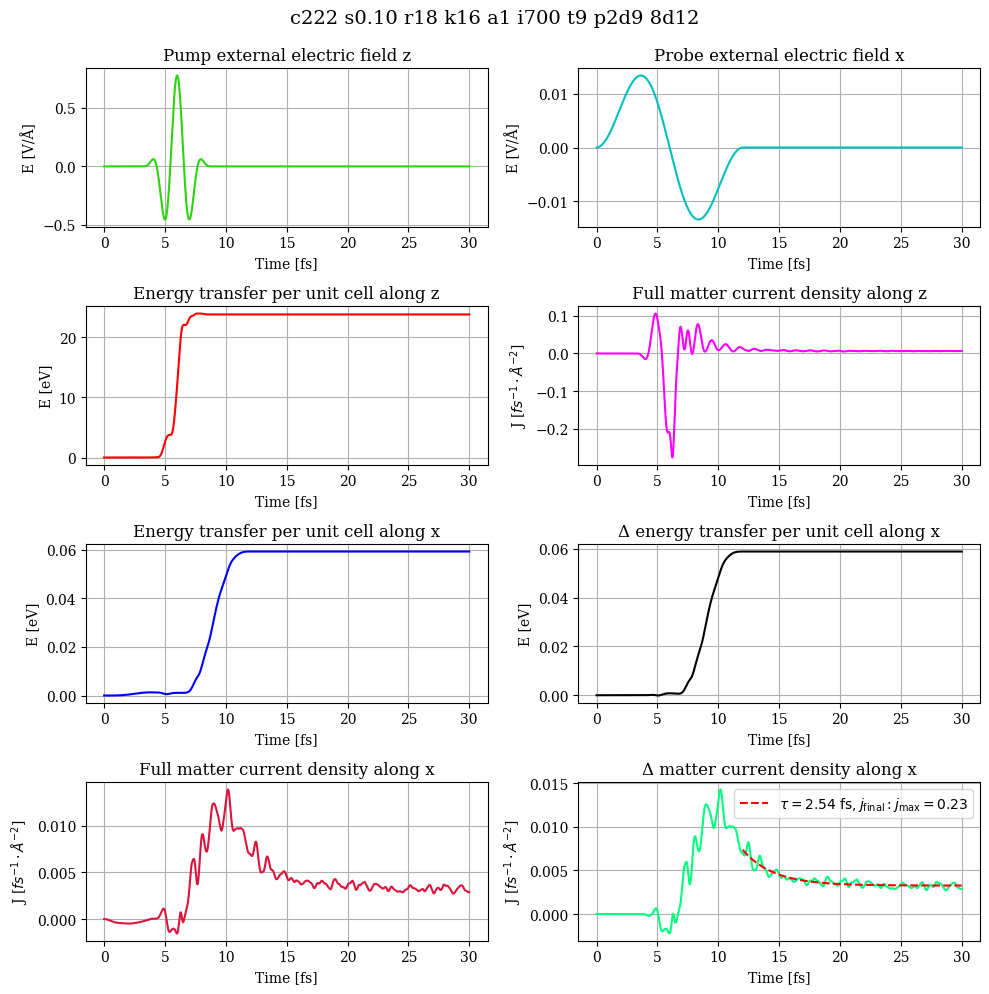

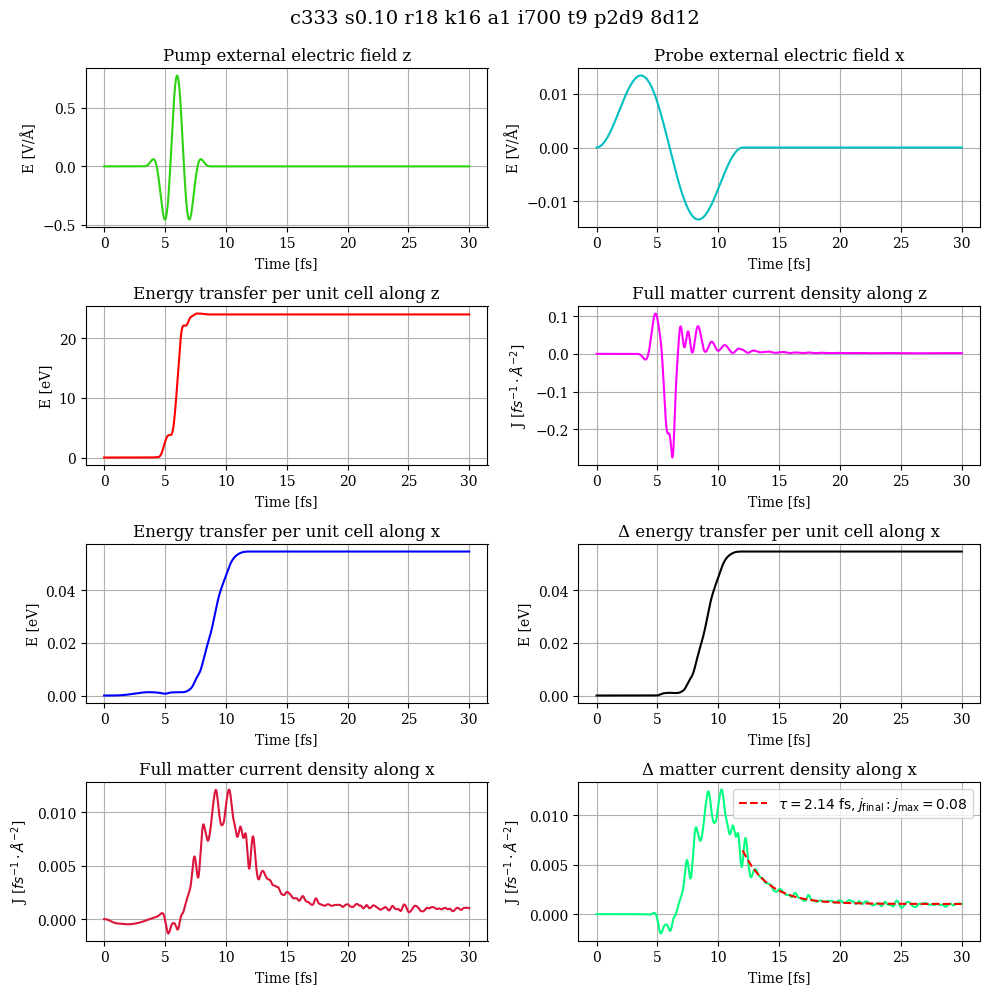

In [11]:
#!/usr/bin/env python
# coding: utf-8

# ## Import

# In[4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import matplotlib.image as mpimg
import os
from PIL import Image
from itertools import product

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Полностью отключить все предупреждения
warnings.filterwarnings("ignore")

os.makedirs("ims", exist_ok=True)
# os.makedirs("ims/current", exist_ok=True)
os.makedirs("ims/all", exist_ok=True)


volume = 160 # для Si в A^3

m0_cut_1 = 5999
m0_cut_2 = 5999
# 3749 (7.5 fms), 5999 (12 fms)

# In[116]:


plt.rcParams['font.family'] = 'serif'
import matplotlib
# matplotlib.use('Agg')
# print(matplotlib.get_backend())


def plot_nonlinear_response_v4(folder, ax, j):


    # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )

    data_probe = pd.read_csv(
        folder + '/probe_pulse_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )

    # Назначим читаемые имена колонкам
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']

    data_probe.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']


    t = data_both['time_fs']


    Jm_both_z  =  data_both['Jm_z']

    Jm_both_x  =  data_both['Jm_x']
    Jm_probe_x =  data_probe['Jm_x']

    Jm_both_y  =  data_both['Jm_y']
    Jm_probe_y =  data_probe['Jm_y']


    El_f_pump_z = data_both['E_ext_z']
    El_f_probe_x = data_both['E_ext_x']


    # 1:Time[fs] 2:Ac_ext_x[fs*V/Angstrom] 3:Ac_ext_y[fs*V/Angstrom] 4:Ac_ext_z[fs*V/Angstrom]
    #5:E_ext_x[V/Angstrom] 6:E_ext_y[V/Angstrom] 7:E_ext_z[V/Angstrom] 8:Ac_tot_x[fs*V/Angstrom]
    # 9:Ac_tot_y[fs*V/Angstrom] 10:Ac_tot_z[fs*V/Angstrom] 11:E_tot_x[V/Angstrom]
    # 12:E_tot_y[V/Angstrom] 13:E_tot_z[V/Angstrom]  14:Jm_x[1/fs*Angstrom^2] 15:Jm_y[1/fs*Angstrom^2] 16:Jm_z[1/fs*Angstrom^2]


    # Построим графики
    plt.figure(figsize=(10, 10))

    # Общий заголовок для всей фигуры
    plt.suptitle(' '.join(re.split('[/_]', folder)), fontsize=14, y=0.99)

    # Первый график: внешнее поле по z
    plt.subplot(4, 2, 1)
    plt.plot(t, El_f_pump_z, label='E_ext_z', color='#2CD311')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [V/Å]')
    plt.title('Pump external electric field z')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    # Второй график: внешнее поле по x
    plt.subplot(4, 2, 2)
    plt.plot(t, El_f_probe_x, label='E_ext_z', color='c')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [V/Å]')
    plt.title('Probe external electric field x')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    # Четвертый график: суммарный ток по z
    plt.subplot(4, 2, 4)
    plt.plot(t, Jm_both_z, color='magenta')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \\cdot Å^{-2}$]')
    plt.title('Full matter current density along z')
    plt.grid(True)

    plt.tight_layout()



    product_both_z = El_f_pump_z * Jm_both_z * volume
    # Разность по времени
    dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
    integral_both_z = np.cumsum(product_both_z * dt)

    product_both_x = El_f_probe_x * Jm_both_x * volume
    # Разность по времени
    dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
    integral_both_x = np.cumsum(product_both_x * dt)

    product_delta_x = El_f_probe_x * (Jm_both_x - Jm_probe_x) * volume
    # Разность по времени
    dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
    integral_delta_x = np.cumsum(product_delta_x * dt)



    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 3)
    # plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.plot(t, -integral_both_z, label='ΔE = E_total - E_initial', color='r')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Energy transfer per unit cell along z')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()



    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 5)
    # plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.plot(t, -integral_both_x, label='ΔE = E_total - E_initial', color='blue')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Energy transfer per unit cell along x')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()


    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 6)
    # plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.plot(t, -integral_delta_x, label='ΔE = E_total - E_initial', color='black')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Δ energy transfer per unit cell along x')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()



    # Суммарный ток по x
    plt.subplot(4, 2, 7)
    plt.plot(t, Jm_both_x, color='#DC143C')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \\cdot Å^{-2}$]')
    plt.title('Full matter current density along x')
    plt.grid(True)
    plt.tight_layout()
    
    
    
    
    delta_Jm_x = Jm_both_x - Jm_probe_x

    
    t_array_cut = np.array(t[m0_cut_1:])[::50]
    j_exp = np.array(delta_Jm_x[m0_cut_1:])[::50]
    # (dummy_t, j0, j_final, tau)
    p0 = [0.03, 0.01, 6.65]   # начальные приближения (n, tau)
    popt, pcov = curve_fit(drude_current_v1, t_array_cut, j_exp, p0=p0)
    j0, j_final, tau= popt
    j_fit = drude_current_v1(0, j0, j_final, tau)

    ratio = j_final/max(delta_Jm_x)

    # Разностный ток по x
    plt.subplot(4, 2, 8)
    plt.plot(t, (Jm_both_x - Jm_probe_x), color='#00FF7F')
    plt.plot(t_array_cut, j_fit, '--', label=rf"$\tau = {tau:.2f}\ \mathrm{{fs}},  j_{{\rm final}} : j_{{\rm max}} = {ratio:.2f}$", color='r')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \\cdot Å^{-2}$]')
    plt.title('Δ matter current density along x')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()







    # lr_data = pd.read_csv(
    #     folder + '/lr_response.data',
    #     comment='#',
    #     delim_whitespace=True,
    #     header=None
    # )

    # lr_data.columns = [
    #     'Energy',        # 1
    #     'Re_sigma_x',    # 2
    #     'Re_sigma_y',    # 3
    #     'Re_sigma_z',    # 4
    #     'Im_sigma_x',    # 5
    #     'Im_sigma_y',    # 6
    #     'Im_sigma_z',    # 7
    #     'Re_eps_x',      # 8
    #     'Re_eps_y',      # 9
    #     'Re_eps_z',      # 10
    #     'Im_eps_x',      # 11
    #     'Im_eps_y',      # 12
    #     'Im_eps_z',      # 13
    # ]


    # # Построение графика изменения энергии во времени
    # plt.subplot(5, 2, 9)
    # plt.plot(lr_data['Energy'][100:], lr_data['Im_eps_z'][100:], label='Im(ε)', color='#00BFFF')
    # plt.xlabel('E [eV]')
    # plt.ylabel('Im(ε)')
    # plt.title('Absorption')
    # plt.grid(True)
    # #plt.legend()
    # plt.tight_layout()

    # # Построение графика изменения энергии во времени
    # plt.subplot(5, 2, 10)
    # plt.plot(lr_data['Energy'][100:], lr_data['Re_eps_z'][100:], label='Re(ε)', color='#FF007F')
    # plt.xlabel('E [eV]')
    # plt.ylabel('Re(ε)')
    # plt.title('Dispersion')
    # plt.grid(True)
    # #plt.legend()
    # plt.tight_layout()
    # # plt.show()

    # plt.savefig("ims/all/" + folder + ".pdf")
    plt.savefig("ims/all/" + str(j)+ '_' + folder + ".png", dpi=200)


# In[ ]:





# ### extract

# In[31]:


def drude_current_v1(dummy_t, j0, j_final, tau):

    # tau = 6.65
    dt = 0.002

    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )

        
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']

    t = data_both['time_fs']
    El_f_probe_x = data_both['E_ext_x']
    
    # --- Задаём поле в дискретных точках ---
    t_array = np.array(t[m0_cut_1:])         # сетка времени
    E_array = -np.array(El_f_probe_x[m0_cut_1:]) 
    
    
    # --- Решение через явный шаг Эйлера ---
    
    j_euler = np.zeros_like(t_array)
    j_euler[0] = j0
    
    for k in range(len(t_array)-1):
        j_euler[k+1] = j_euler[k] + dt * (-(j_euler[k]-j_final)/tau)


    return j_euler[::50]


def extract_c_num(s):
    start = s.index('c') + 1
    end = s.index('_', start)
    return int(s[start:end])

def extract_s_num(s):
    start = s.index('_s') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_k_num(s):
    start = s.index('_k') + 2
    end = s.index('_', start)
    return int(s[start:end])

def extract_a_num(s):
    start = s.index('_a') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_r_num(s):
    start = s.index('_r') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_i_num(s):
    start = s.index('_i') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_p(s):
    match = re.search(r'p([^_]+)', s)
    if match:
        return match.group(1)


# ## Plots

# In[75]:


ax = 'z'

folders = [name for name in os.listdir('.') if os.path.isdir(os.path.join('.', name))]

# folders = [f for f in folders if f.startswith('c')]
folders = [f for f in folders 
           if f.startswith('c') 
           and os.path.isfile(os.path.join(f, 'probe_pulse_rt.data')) 
           and not os.path.isdir(os.path.join(f, 'restart'))]


# print(folders)


# Сортировка: сначала по c, потом по s, потом по k
sorted_folders = sorted(folders, key=lambda s: (extract_p(s), extract_c_num(s), extract_r_num(s), extract_s_num(s), extract_k_num(s), extract_a_num(s), extract_i_num(s)))


# In[74]:


j=0
for folder in sorted_folders:
    j=j+1
    plot_nonlinear_response_v4(folder, ax, j)


# In[ ]:




